# Clustering

This codelab gives a hands-on introduction to using clustering as a compression technique.

In [52]:
import math
import numpy as np
import tensorflow as tf

In [53]:
!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Noto Sans'

# Helper methods for Quantization

To start off, let us bring back our quantization related code from chapter 2. Nothing new to see here, but we included these methods in this colab to compare against clustering.

In [54]:
def get_scale(x_min, x_max, b):
  # Compute scale as discussed.
  return (x_max - x_min ) * 1.0 / (2**b)

"""Quantizing the given vector x."""
def quantize(x, x_min, x_max, b):
  # Clamp x to lie in [x_min, x_max].
  x = np.minimum(x, x_max)
  x = np.maximum(x, x_min)

  # Compute scale as discussed.
  s = get_scale(x_min, x_max, b)
  x_q = np.floor((x - x_min) / s)

  # Clamping the quantized value to be less than (2^b - 1).
  x_q = np.minimum(x_q, 2**b - 1)

  # Return x_q as an unsigned integer.
  # Although uint8 is the smallest data type supported by numpy, in this colab
  # we will be trying different values of b, some of which are greater than 8.
  return x_q.astype(np.uint32)

def dequantize(x_q, x_min, x_max, b):
  # Compute the value of r the same way.
  s = get_scale(x_min, x_max, b)
  x = x_min + (s * x_q)
  return x

def compute_reconstruction_error(x, decoded_x):
  """Compute a simple mean squared error (MSE) loss."""
  loss = tf.math.reduce_mean((x - decoded_x)**2)
  return loss

def simulate_quantization(x, b):
  x_min = np.min(x)
  x_max = np.max(x)
  x_q = quantize(x, x_min, x_max, b)
  x_dq = dequantize(x_q, x_min, x_max, b)
  x_dq = np.clip(x_dq, x_min, x_max)
  reconstruction_error = compute_reconstruction_error(x, x_dq).numpy()
  return x_dq, reconstruction_error

# Helper methods for clustering.

In [55]:
def get_clustering_loss(x_var, centroids_var):
  """Computing the loss to optimize."""
  # Compute the pairwise squared distance between the input (x) and the
  # centroids.
  distances = tf.subtract(tf.reshape(x_var, (-1, 1)), centroids_var) ** 2
  best_distances = tf.math.reduce_min(distances, axis=1)
  return tf.reduce_mean(best_distances)

def get_centroids(x, num_clusters, num_steps=10, learning_rate=1e-3, 
                  verbose=1):
  """Get `num_clusters` centroids for the given value of `x`."""
  # Pick initial centroids that are evenly spaced.
  x_sorted = np.sort(x.flatten())
  centroids_init = np.linspace(x_sorted[0], x_sorted[-1], num_clusters)

  # Construct the variables in this optimization problem.
  # We will not update 'x', and hence it is not trainable.
  x_var = tf.Variable(initial_value=x_sorted, trainable=False)

  # The centroids are going to be updated, thus they will be trainable.
  centroids_var = tf.Variable(initial_value=centroids_init, trainable=True)

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  for step_idx in range(num_steps):
    with tf.GradientTape() as tape:
      loss = get_clustering_loss(x_var, centroids_var)
      if verbose == 2 or (
          verbose == 1 and
          ((step_idx + 1) % ((int)(num_steps / 5)) == 0)):
        print(f'Step: {step_idx + 1}, Loss: {loss:.5f}.')

    # Compute the gradients w.r.t. only the centroids_var.
    gradients = tape.gradient(loss, [centroids_var])
    
    # Update the centroids_var.
    opt.apply_gradients(zip(gradients, [centroids_var]))
  return centroids_var


def encode_x(x, centroids):
  """Encode the given `x` using the given centroids."""
  x_flattened = tf.reshape(x, [-1])
  # Compute pairwise squared distances between all the elements of x and the
  # centroids.
  distances = tf.subtract(
      tf.reshape(x_flattened, (-1, 1)), 
      centroids) ** 2
  
  # Now compute the distance to the closest centroid.
  best_distances = tf.math.reduce_min(distances, axis=1)
  
  # Create an indicator variable matrix, where 1.0 at index [i][j] denotes that
  # for the i-th element, the j-th centroid is the closest.
  is_closest = tf.cast(
    tf.equal(distances, tf.reshape(best_distances, (-1, 1))),
    dtype=tf.float64)
  
  # Now lookup the centroid indices.
  encoded_x_flattened = tf.math.argmax(is_closest, axis=1)

  # Finally, reshape the array to the original shape.
  return tf.reshape(encoded_x_flattened, tf.shape(x))


def decode_x(encoded_x, centroids):
  """Decode the x back from the centroids."""
  encoded_x_flattened = tf.reshape(encoded_x, [-1])
  # Lookup the centroids for their values, and then reshape it back to the
  # original shape.
  return tf.reshape(
      tf.gather(centroids, encoded_x),
      tf.shape(encoded_x))


def simulate_clustering(x, num_clusters, num_steps=20, learning_rate=5e-3, 
                        verbose=1):
  def vprint(v, str):
    if v:
      print(str)

  vprint(verbose, 'Computing the centroids.')
  computed_centroids = get_centroids(
      x, num_clusters, num_steps=num_steps, learning_rate=learning_rate, 
      verbose=verbose)
  
  vprint(verbose, 'Encoding x using the computed centroids.')
  encoded_x = encode_x(x, computed_centroids)

  # Now finally decode the encoded x, and compute the reconstruction error.
  vprint(verbose, 'Decoding x using the computed centroids.')
  decoded_x = decode_x(encoded_x, computed_centroids)
  reconstruction_error = compute_reconstruction_error(x, decoded_x)
  vprint(verbose, f'Final reconstruction error: {reconstruction_error:.4f}.')
  return decoded_x, computed_centroids, reconstruction_error

# Methods for comparing Clustering and Quantization

In [56]:
# Compute various statistics related to size when using quantization /
# clustering.
class CompressionStats():
  """A helper class that stores and computes different compression metrics."""
  def __init__(
      self, num_elements, 
      num_quantization_bits=8, 
      num_clusters=1000, 
      floating_point_word_size=4):
    self.num_elements = num_elements
    self.num_quantization_bits = num_quantization_bits
    self.num_clusters = num_clusters
    self.floating_point_word_size = floating_point_word_size
  
  def get_original_size_bytes(self):
    return self.num_elements * self.floating_point_word_size
  
  def get_quantized_size_bytes(self):
    return (self.num_elements * self.num_quantization_bits) / 8.0

  def get_clustered_size_bytes(self):
    codebook_size_bytes = self.num_clusters * self.floating_point_word_size
    encoded_img_size_bytes = (
        self.num_elements * np.math.log2(self.num_clusters)
    ) / 8.0
    return codebook_size_bytes + encoded_img_size_bytes
  
  def get_quant_vs_clustering_compression_ratio(self):
    return self.get_quantized_size_bytes() / self.get_clustered_size_bytes()

  def get_original_vs_clustering_compression_ratio(self):
    return self.get_original_size_bytes() / self.get_clustered_size_bytes()


def compute_compression_ratio(num_elements, num_quantization_bits, num_clusters, 
                              floating_point_word_size=4, verbose=2):
  stats = CompressionStats(num_elements, num_quantization_bits, num_clusters,
                           floating_point_word_size=floating_point_word_size)
  
  if verbose:
    print(f'Original input size: {stats.get_original_size_bytes()} bytes.')
    print(f'Quantized input size: {stats.get_quantized_size_bytes():.2f} bytes.')
    print(f'Clustered input size: {stats.get_clustered_size_bytes():.2f} bytes.')
    print('Compression Ratio (Quant Size / Clustered Size): '
          f'{stats.get_quant_vs_clustering_compression_ratio():.3f}.')
  
  return stats

# Compress a given tensor.

Let's try out clustering to compress a given tensor, so that we can build an intuition about how clustering works.

In [57]:
# Setting a seed here helps us reproduce the same output over multiple runs.
np.random.seed(1337)

# Let's create a tensor with a bimodal distribution, i.e., with two peaks, and
# examine how clustering works.
x = np.concatenate((
    np.random.normal(size=25000, loc=-2.0, scale=0.5),
    np.random.normal(size=25000, loc=2.0, scale=0.5)))

In [58]:
num_clusters = 8
x_decoded, centroids, reconstruction_error = simulate_clustering(
    x, num_clusters, num_steps=5000, learning_rate=2e-1)

Computing the centroids.
Step: 1000, Loss: 0.03061.
Step: 2000, Loss: 0.02911.
Step: 3000, Loss: 0.02911.
Step: 4000, Loss: 0.02911.
Step: 5000, Loss: 0.02911.
Encoding x using the computed centroids.
Decoding x using the computed centroids.
Final reconstruction error: 0.0291.


## Visualizing where the centroids are.

In [59]:
# Let us also compute the quantization ranges to compare.
num_quantization_bits = int(math.log2(num_clusters))
x_dq, _ = simulate_quantization(x, num_quantization_bits)
quant_buckets = list(set(x_dq))

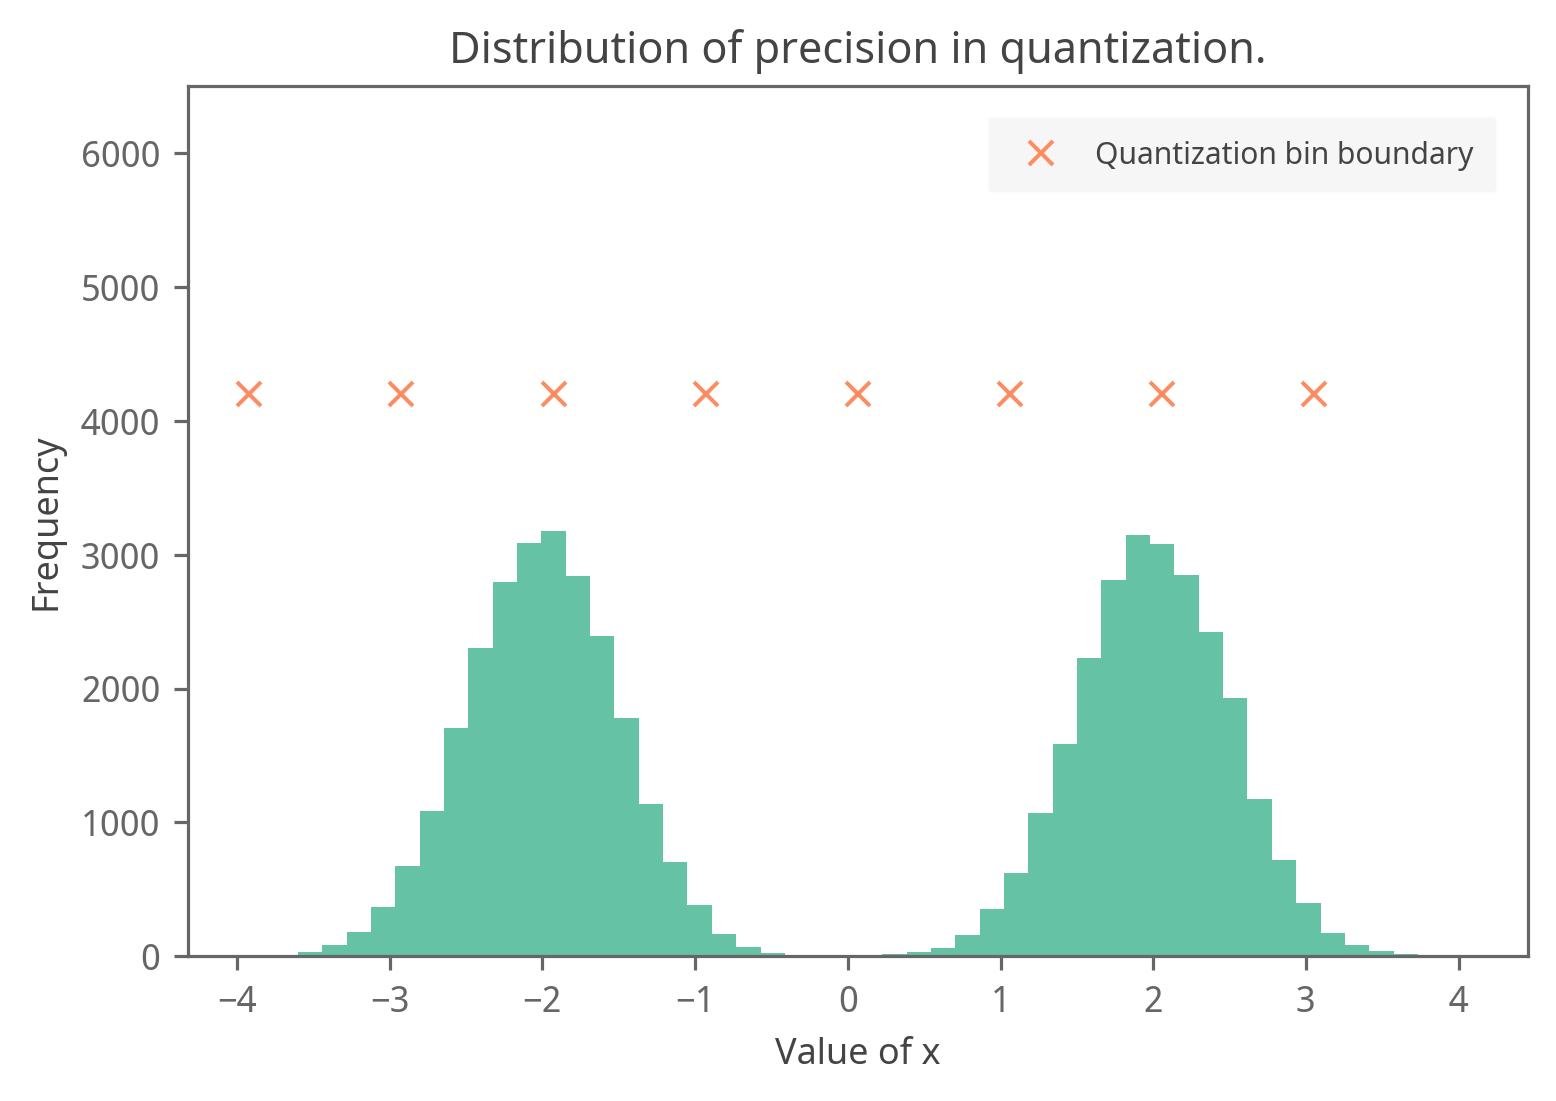

In [60]:
plt.hist(x, bins=50)
plt.plot(quant_buckets, [4200] * len(quant_buckets), marker='x', 
         linestyle = 'None')
plt.ylim(0, 6500)
plt.legend(['Quantization bin boundary'])

plt.xlabel('Value of x')
plt.ylabel('Frequency')
plt.title('Distribution of precision in quantization.')
plt.show()

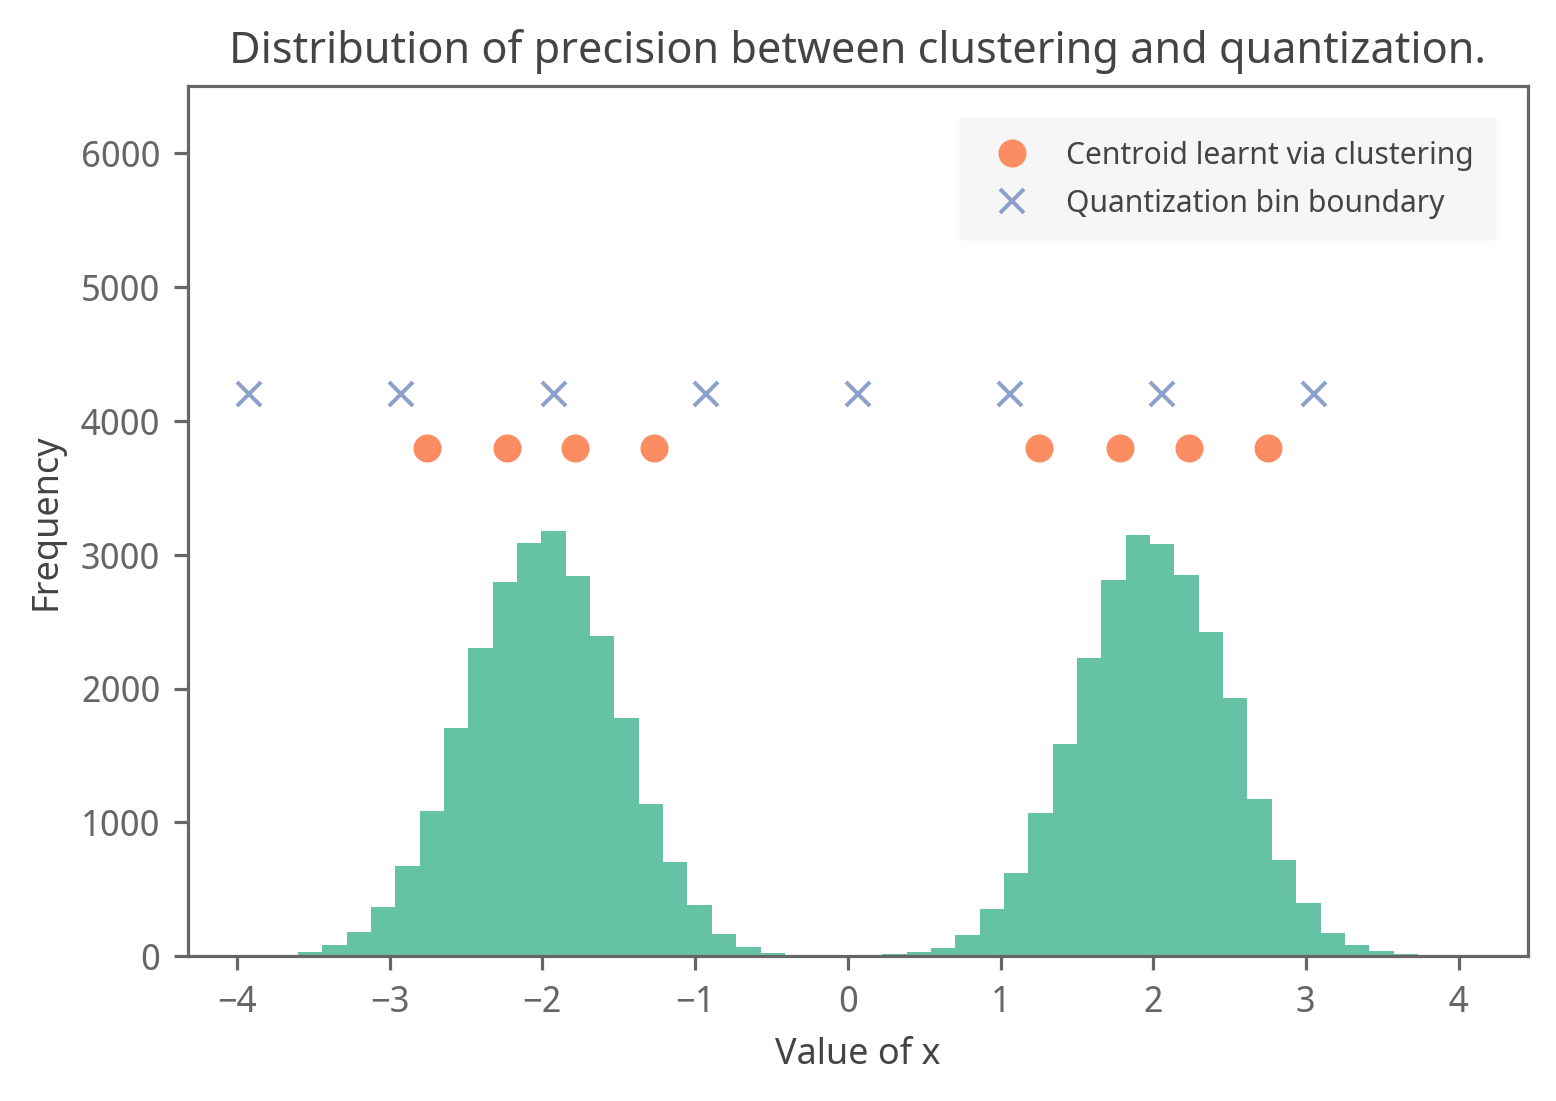

In [61]:
plt.hist(x, bins=50)
plt.plot(centroids.numpy(), [3800] * centroids.shape[0], 
         marker='o', linestyle = 'None')
plt.plot(quant_buckets, [4200] * len(quant_buckets), marker='x', 
         linestyle = 'None')
plt.ylim(0, 6500)
plt.legend(['Centroid learnt via clustering', 'Quantization bin boundary'])

plt.xlabel('Value of x')
plt.ylabel('Frequency')
plt.title('Distribution of precision between clustering and quantization.')
plt.show()

## Number of clusters v/s reconstruction error.

In [62]:
def compute_reconstruction_errors(x, num_clusters_values):
  """Compute reconstruction errors for different values of num_clusters."""
  reconstruction_errors = []
  compression_ratios = []
  reconstruction_errors_quant = []
  compression_ratios_vs_quant = []

  num_elements = x.flatten().shape[0]
  for num_clusters in num_clusters_values:
    _, _, reconstruction_error = simulate_clustering(
      x, num_clusters, num_steps=500, verbose=0)
    reconstruction_errors.append(reconstruction_error.numpy())

    # Do the same for quantization, such that the number of clusters matches the
    # number of quantization ranges.
    num_quantization_bits = int(math.log2(num_clusters))
    _, reconstruction_error_quant = simulate_quantization(
        x, num_quantization_bits)
    reconstruction_errors_quant.append(reconstruction_error_quant)

    # Compute various stats related to both clustering and quantization.
    stats = CompressionStats(num_elements, 
                             num_quantization_bits=math.log2(num_clusters),
                             num_clusters=num_clusters)
    compression_ratios.append(
        stats.get_original_vs_clustering_compression_ratio())
    compression_ratios_vs_quant.append(
        stats.get_quant_vs_clustering_compression_ratio())
  
  return (num_clusters_values, reconstruction_errors, compression_ratios, 
          reconstruction_errors_quant, compression_ratios_vs_quant)

In [63]:
(num_clusters_values, reconstruction_errors, compression_ratios, 
 reconstruction_errors_quant, compression_ratios_vs_quant) = compute_reconstruction_errors(
    x, [int(2**x) for x in range(1, 12)])

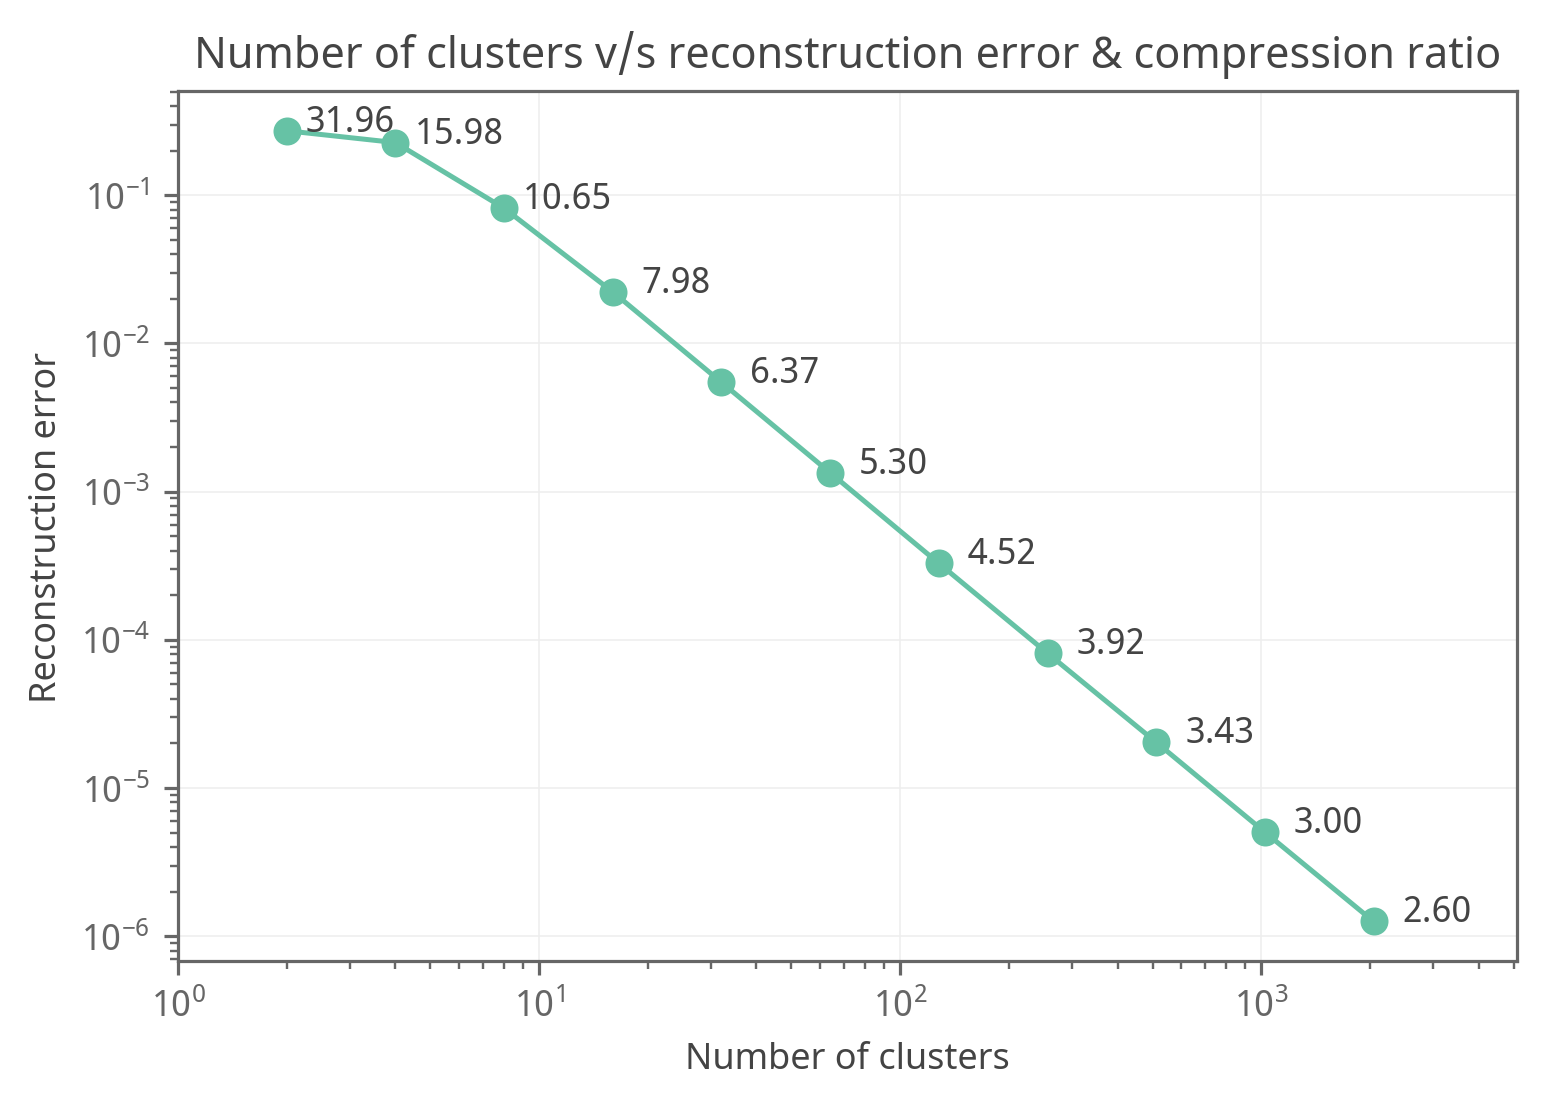

In [64]:
# Now plot the # of clusters v/s reconstruction error & compression ratio plot.
plt.plot(num_clusters_values, reconstruction_errors, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Reconstruction error')
plt.xscale('log')
plt.yscale('log')
plt.grid()

for idx, size in enumerate(compression_ratios):
  plt.text(num_clusters_values[idx] * 1.5, reconstruction_errors[idx], 
           f'{compression_ratios[idx]:.2f}', ha='center')

plt.xlim((1, num_clusters_values[-1] * 2.5))
plt.title('Number of clusters v/s reconstruction error & compression ratio')
plt.show()

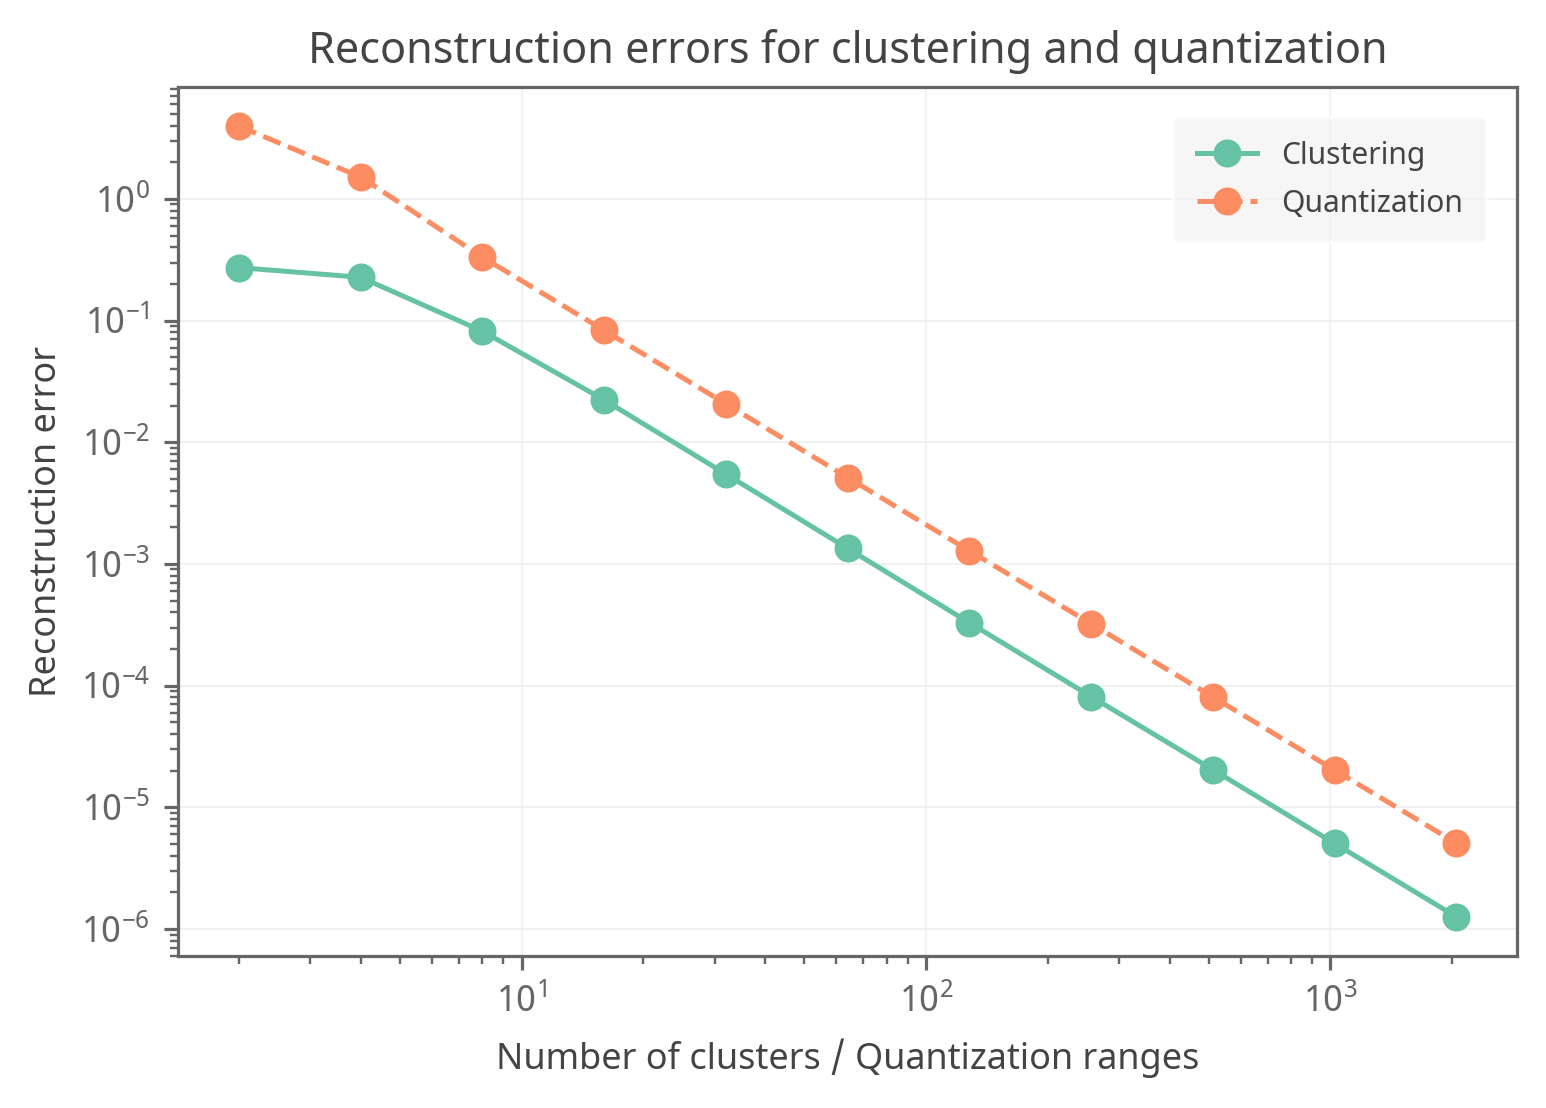

In [65]:
# Now plot the # of clusters v/s reconstruction error & compression ratio plot.
plt.plot(num_clusters_values, reconstruction_errors, marker='o')
plt.plot(num_clusters_values, reconstruction_errors_quant, marker='o', 
         linestyle='--')
plt.xlabel('Number of clusters / Quantization ranges')
plt.ylabel('Reconstruction error')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.legend(['Clustering', 'Quantization'])
plt.title('Reconstruction errors for clustering and quantization')
plt.show()

# Mars Rover Problem

In this section, we will revisit the Mars Rover problem to demonstrate how does Clustering compare to Quantization.

In [66]:
! wget -q https://github.com/EfficientDL/book/raw/main/codelabs/Chapter-02-Compression-Techniques/pia23378-16.jpeg

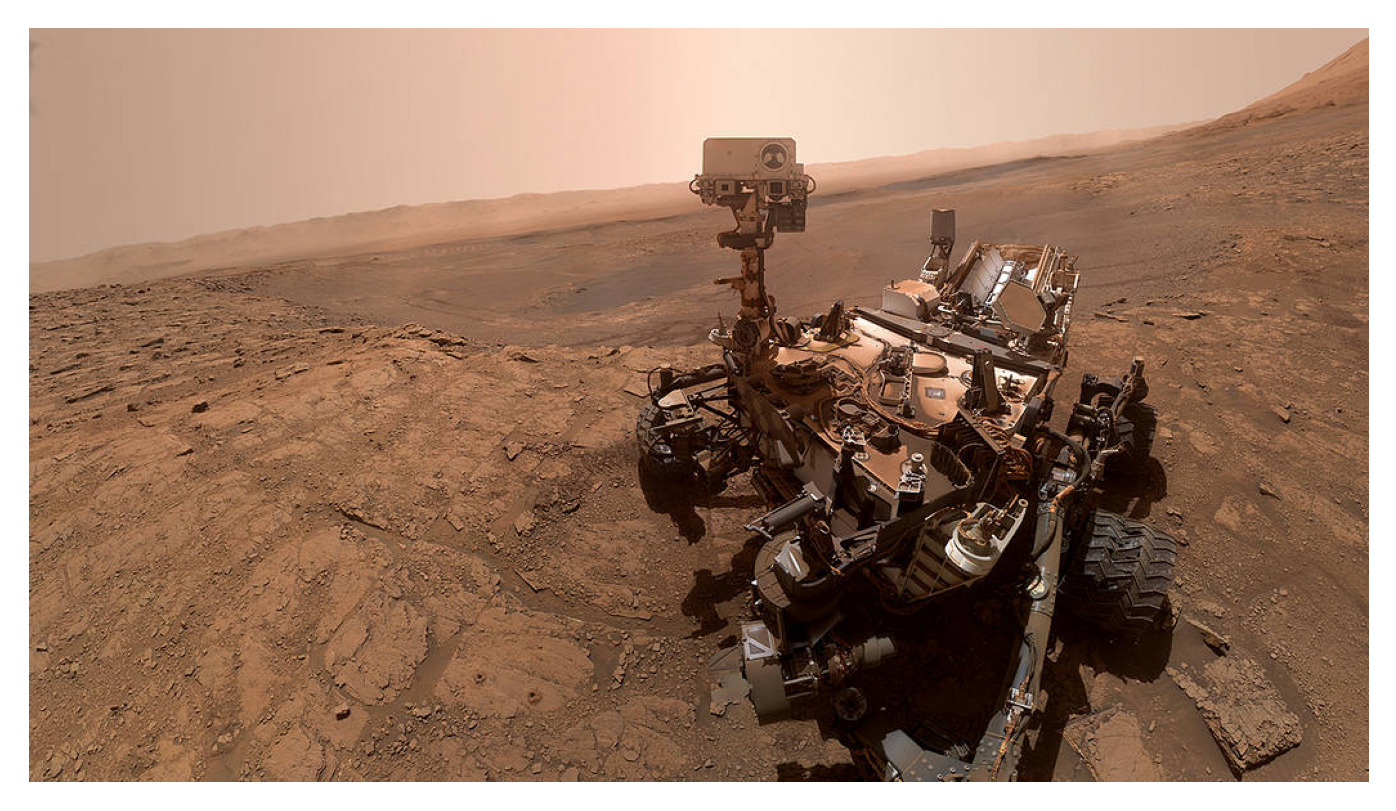

In [67]:
img = (mpimg.imread('pia23378-16.jpeg') / 255.0)
plt.axis('off')
plt.imshow(img)
plt.show()

## Let's start with trying quantization.

In [68]:
def simulate_transmission_quantization(img, b):
  decoded_image, reconstruction_error = simulate_quantization(img, b)
  plt.axis('off')
  plt.imshow(decoded_image)
  print('Reconstruction error: '
        f'{reconstruction_error:.5f}')

Reconstruction error: 0.00031


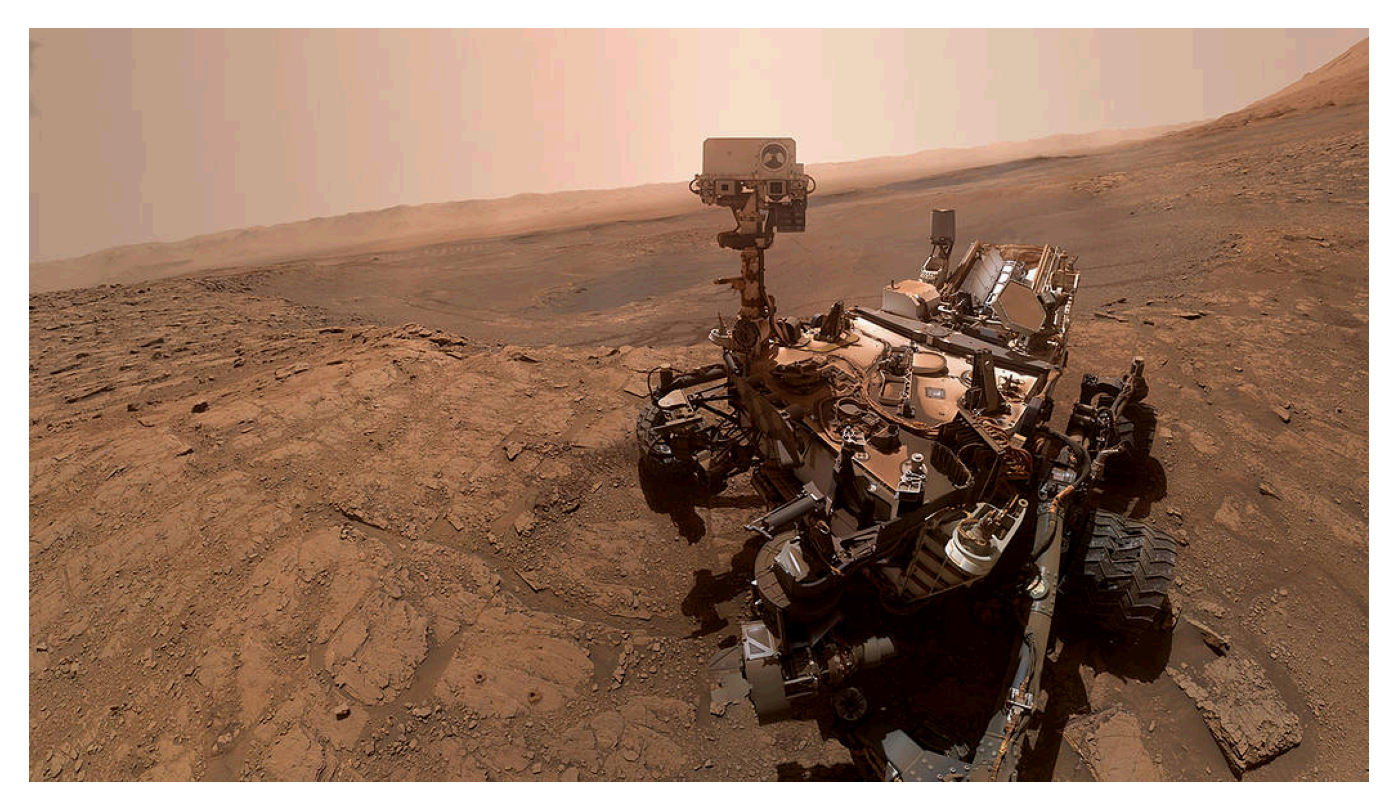

In [69]:
num_bits = 5
simulate_transmission_quantization(img, num_bits)

Reconstruction error: 0.00126


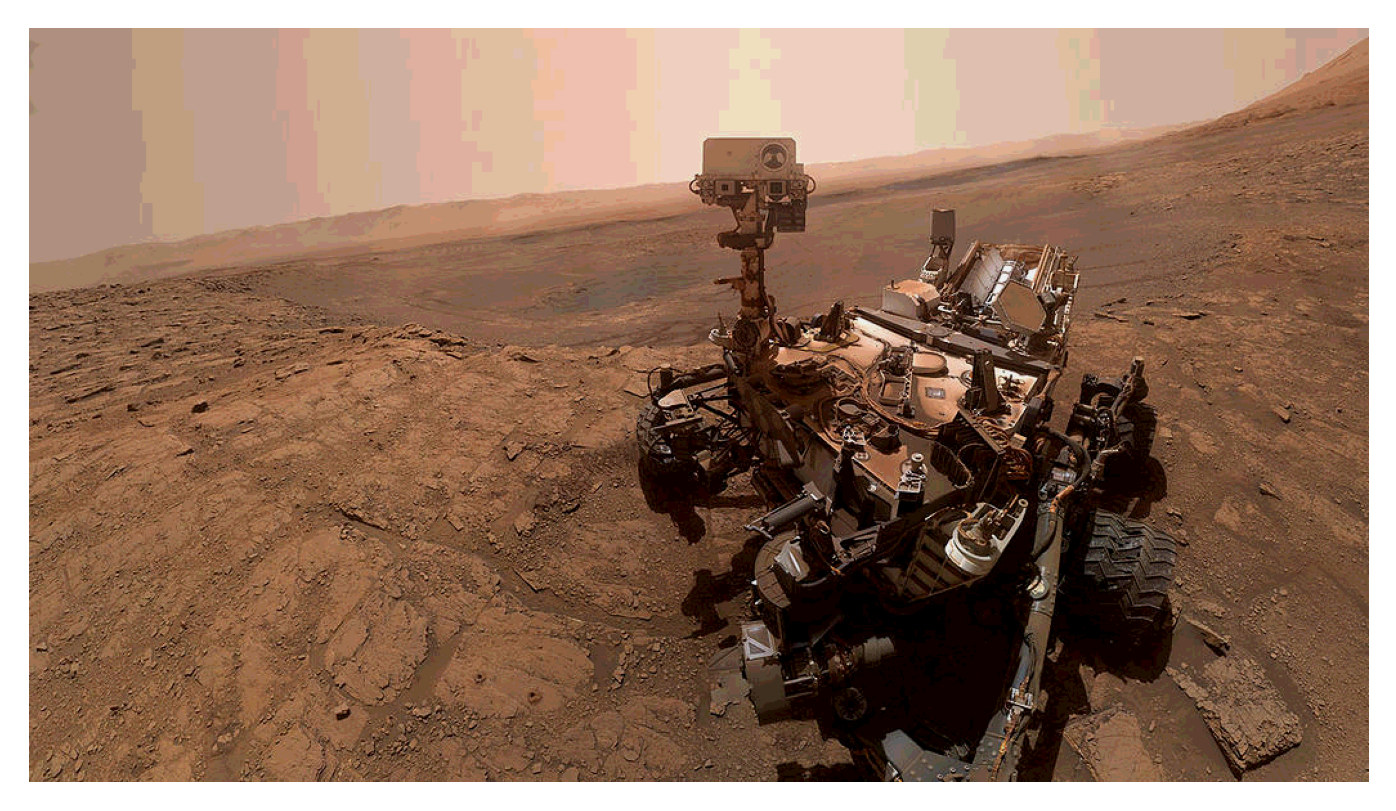

In [70]:
simulate_transmission_quantization(img, 4)

The reconstruction error with 5 bits is 0.01756. If we reduce the number of bits further, the image starts to get blurry.

## Can we do better with clustering? 

The goal in this scenario is to use clustering to outperform quantization. Let us implement a method that simulates the transmission and measures the reconstruction error.

In [71]:
def simulate_transmission_clustering(img, num_clusters):
  decoded_img, _, reconstruction_error = simulate_clustering(
      img, num_clusters, num_steps=10, learning_rate=2e-1, verbose=2)
  print(f'Reconstruction error: {reconstruction_error:.4f}.')
  plt.axis('off')
  plt.imshow(decoded_img) 

Let us try clustering with 22 clusters and centroids.

Computing the centroids.
Step: 1, Loss: 0.00019.
Step: 2, Loss: 0.00019.
Step: 3, Loss: 0.00019.
Step: 4, Loss: 0.00019.
Step: 5, Loss: 0.00019.
Step: 6, Loss: 0.00019.
Step: 7, Loss: 0.00019.
Step: 8, Loss: 0.00019.
Step: 9, Loss: 0.00019.
Step: 10, Loss: 0.00019.
Encoding x using the computed centroids.
Decoding x using the computed centroids.
Final reconstruction error: 0.0002.
Reconstruction error: 0.0002.


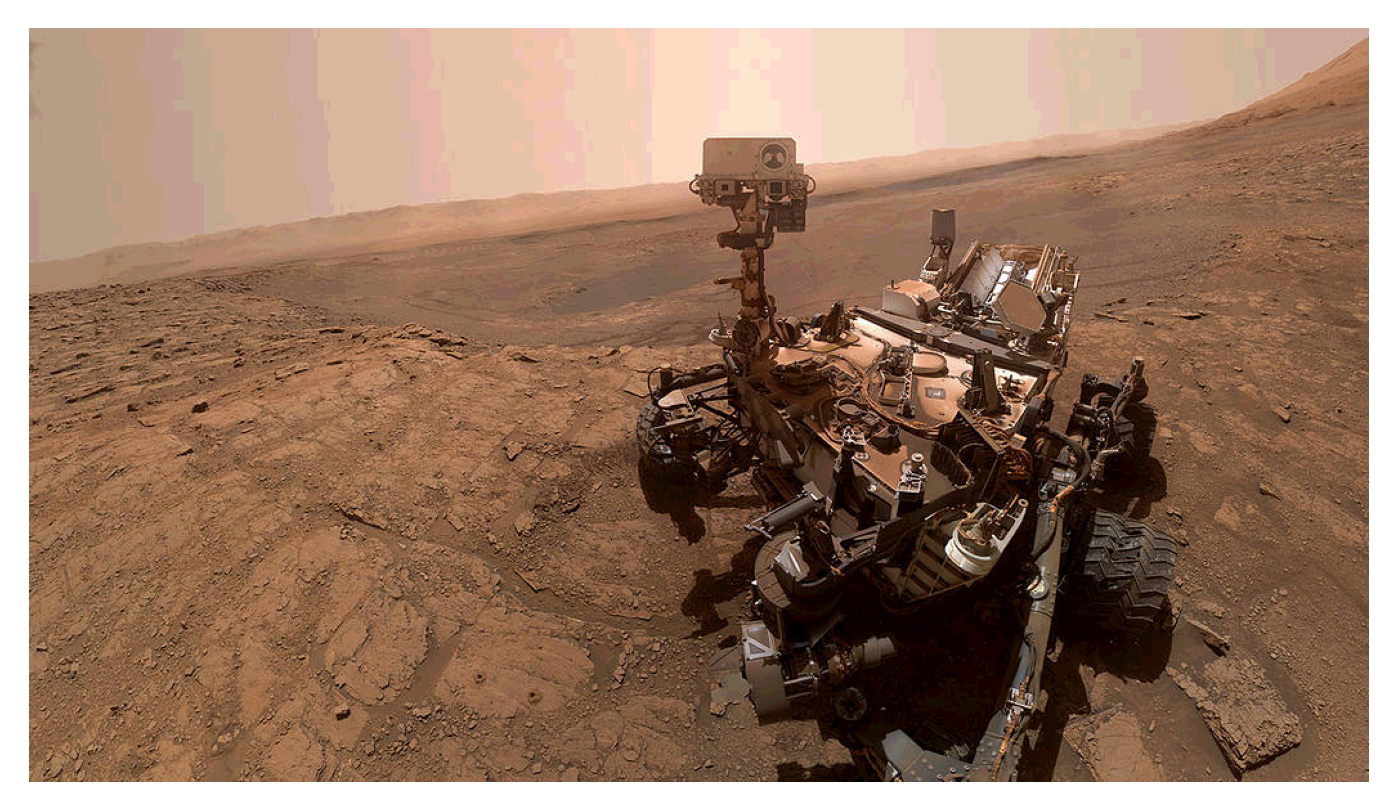

In [72]:
num_clusters = 22
simulate_transmission_clustering(img, num_clusters)

Notice that the reconstruction error using clustering with 22 clusters (0.0002) is lower than that using quantization with 5 bits (0.0003). 

In [73]:
stats = compute_compression_ratio(img.size, num_bits, num_clusters)

Original input size: 7320312 bytes.
Quantized input size: 1143798.75 bytes.
Clustered input size: 1020226.46 bytes.
Compression Ratio (Quant Size / Clustered Size): 1.121.


Therefore the clustered representation is **12.1%** smaller than the quantized representation.

# Simulating clustering on a dummy dense fully-connected layer

In [74]:
np.random.seed(10007)

def get_random_matrix(shape):
  return np.random.normal(0.0, 1.0, size=shape)

# Populate the inputs, weights and bias.
inputs = get_random_matrix([100, 300])
weights = get_random_matrix([300, 500])
bias = get_random_matrix([500])

y = np.maximum(np.matmul(inputs, weights) + bias, 0)

## Using quantization with the dummy dense layer.

Let's measure the reconstruction errors when using quantization.

In [75]:
num_bits = 8
weights_dequantized, weights_reconstruction_error_quant = simulate_quantization(
    weights, num_bits)
print(f'Weights reconstruction error: {weights_reconstruction_error_quant:.5f}')

y_via_quant = np.maximum(np.matmul(inputs, weights_dequantized) + bias, 0)
output_reconstruction_error_quant = compute_reconstruction_error(
    y, y_via_quant).numpy()
print(f'Output reconstruction error: {output_reconstruction_error_quant:.4f}')

Weights reconstruction error: 0.00036
Output reconstruction error: 0.0581


## Using clustering with the dummy dense layer.

In [76]:
num_clusters = 128
weights_decoded, _, weights_reconstruction_error = simulate_clustering(
    weights, num_clusters)
print('Weights reconstruction error: '
      f'{weights_reconstruction_error:.4f}')

Computing the centroids.
Step: 4, Loss: 0.00036.
Step: 8, Loss: 0.00036.
Step: 12, Loss: 0.00036.
Step: 16, Loss: 0.00036.
Step: 20, Loss: 0.00036.
Encoding x using the computed centroids.
Decoding x using the computed centroids.
Final reconstruction error: 0.0004.
Weights reconstruction error: 0.0004


In [77]:
y_via_clustering = np.maximum(np.matmul(inputs, weights_decoded) + bias, 0)
output_reconstruction_error_clustering = compute_reconstruction_error(
    y, y_via_clustering).numpy()
print(f'Output reconstruction error: {output_reconstruction_error_clustering:.4f}')

Output reconstruction error: 0.0543


Let us now compute the compression ratio v/s quantization for the dense layer.

In [78]:
compute_compression_ratio(weights.size, num_bits, num_clusters)

Original input size: 600000 bytes.
Quantized input size: 150000.00 bytes.
Clustered input size: 131762.00 bytes.
Compression Ratio (Quant Size / Clustered Size): 1.138.


Clustering achieves a very similar output reconstruction error as quantization, and leads to a weights encoding that is about **13.8% smaller**. 

However, note that if the size of the weight matrix was very small, the size of the codebook would have dominated the total size of the encoded representation. Since our weight matrix was reasonable (100x300), it allowed us to save space when compared to quantization.